### [4주차 과제]
- 14기 김유민
- 사용 데이터 : fashion_mnist 데이터셋

# CNN에 실제 데이터셋 적용하기: MNIST dataset

---



In [1]:
# FashionMNIST 데이터셋 불러오기
from torchvision.datasets import FashionMNIST

In [3]:
# 기본 패키지
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# 파이토치
import torch 
import torch.nn as nn
import torchvision.transforms as transforms #이미지 변환 툴
import torch.nn.init #텐서에 초기값을 줌
from torch.utils.data import  Dataset, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

## Fashion_MNIST dataset

- 28×28 픽셀의 흑백 이미지

- 70,000장 (train set : 60,000 / test set : 10,000) 으로 구성

- 총 10개의 클래스(의류,가방)등의 이미지를 포함한 데이터셋

In [15]:
# 이미지를 텐서로 변경
transform = transforms.Compose([transforms.ToTensor()]) 

In [16]:
# Fashion MNIST 훈련 데이터셋
fmnist_train = FashionMNIST(
    root      = 'FashionMNIST_data/', 
    train     = True,
    transform = transform,
    download  = True    
)

fmnist_test = FashionMNIST(
    root      = 'FashionMNIST_data/', 
    train     = False,
    transform = transform,
    download  = True
)

In [26]:
# 100개 단위의 미니 배치로 구분지어 인공신경망 학습
train_loader = DataLoader(dataset = fmnist_train, batch_size  = 100, shuffle=True)
test_loader = DataLoader(dataset = fmnist_test, batch_size  = 100, shuffle=True)

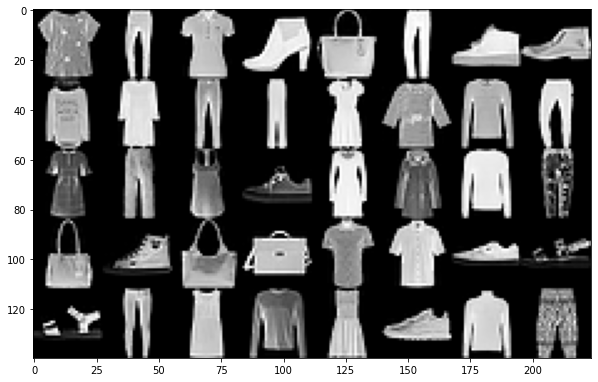

In [27]:
# 데이터(이미지) 체크 !! 100개중에 40개 -> 가로(28) x 세로(28) x 흑백(1) size
from torchvision import utils

dataiter       = iter(train_loader)   # iter함수로 iteration 객체 가져오기
images, labels = next(dataiter) # next함수로 다음 배치 1개 갖고오기

img   = utils.make_grid(images[:40], padding=0)
npimg = img.numpy()
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

In [30]:
# 총 10개의 class label 지정해주기
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

## CNN 모델 설계

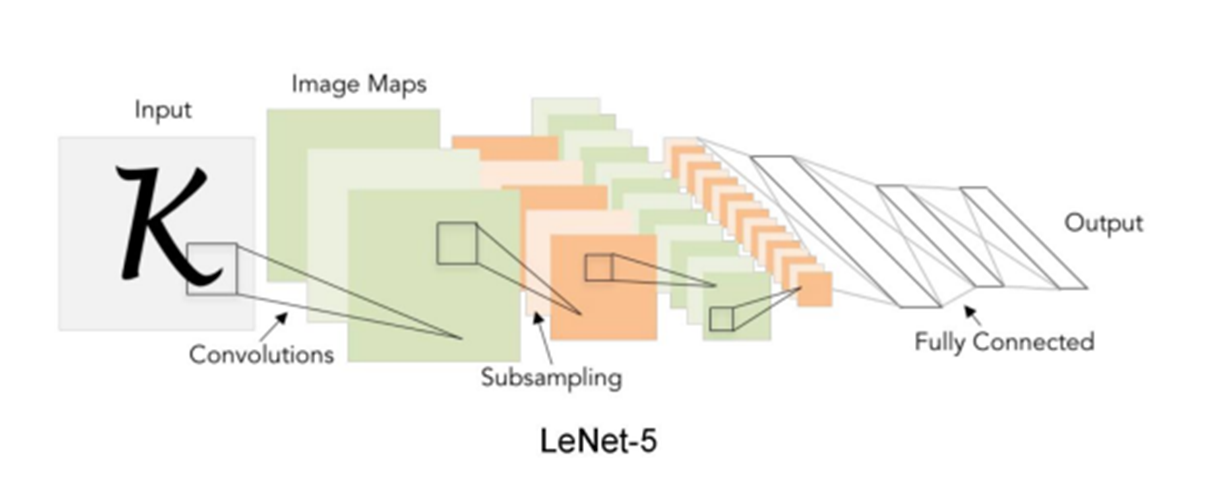

### 시도1 
- Accuracy: 0.809499979019165
- convolution1 -> leakyrelu -> maxpool -> convolution1 -> leakyrelu -> maxpool

In [77]:
# 하이퍼파라미터
learning_rate = 0.001 
training_epochs = 15
batch_size = 100 

In [78]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        # first layer
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),   # 3x3필터를 가진 convolution
            torch.nn.LeakyReLU(),   # activation function
            torch.nn.MaxPool2d(kernel_size=2, stride=2))   # pooling

        # second layer
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))   # pooling

        # fully-connected layer 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

        # fully-connected layer 한정으로 가중치 초기화
        torch.nn.init.kaiming_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = out.view(out.size(0), -1)   # fully-connected layer를 위해서 Flatten
        out = self.fc(out) # fully-connected layer 통과
        return out

In [79]:
model1 = CNN().to(device)   #모델 정의 및 gpu에 할당

In [80]:
criterion = torch.nn.CrossEntropyLoss().to(device)   # loss function 정의
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)   #optimizer 정의, Adam으로 설정

In [81]:
def training_model(model, data, epochs):
  total_batch = len(data)

  for epoch in range(epochs):
    avg_cost = 0

    for X, Y in data:  #data_loader에 배치들이 저장되어 있음. 한 iteration당 한 개의 배치를 꺼내와서 사용
        X = X.to(device)   #이미지
        Y = Y.to(device)   #레이블(해당 이미지가 뜻하는 숫자)

        optimizer.zero_grad()   #지난 iteration에서 계산했던 기울기 초기화
        hypothesis = model(X)   #순전파 과정으로 예측값 도출
        cost = criterion(hypothesis, Y)   #예측값과 실제값을 비교한 loss
        cost.backward()   #역전파, 기울기 계산
        optimizer.step()   #optimizer로 가중치 갱신

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

In [82]:
#모델 학습
training_model(model = model1, data = train_loader, epochs = training_epochs)

[Epoch:    1] cost = 0.503602445
[Epoch:    2] cost = 0.336002171
[Epoch:    3] cost = 0.298235834
[Epoch:    4] cost = 0.26916486
[Epoch:    5] cost = 0.252036959
[Epoch:    6] cost = 0.236417904
[Epoch:    7] cost = 0.220502347
[Epoch:    8] cost = 0.206914842
[Epoch:    9] cost = 0.19514817
[Epoch:   10] cost = 0.185469031
[Epoch:   11] cost = 0.175071642
[Epoch:   12] cost = 0.167322129
[Epoch:   13] cost = 0.158617049
[Epoch:   14] cost = 0.15080072
[Epoch:   15] cost = 0.143877909


In [85]:
with torch.no_grad():
    X_test = fmnist_test.test_data.view(len(fmnist_test), 1, 28, 28).float().to(device)
    Y_test = fmnist_test.test_labels.to(device)

    prediction = model1(X_test)   # 학습한 모델로 test 데이터의 예측값 도출(각 숫자에 해당할 확률)
    correct_prediction = torch.argmax(prediction, 1) == Y_test   # 모든 확률 중에서 가장 큰 확률을 가진 숫자를 예측값으로 지정하고 이를 실제값과 비교
    accuracy = correct_prediction.float().mean()   # 정확도 계산
    print('Accuracy:', accuracy.item())

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.809499979019165


### 시도2
- Accuracy: Accuracy: 0.9039999842643738
- dropout : 0.5 (A good value for dropout in a hidden layer is between 0.5 and 0.8)
- batchnorm(x) 배치정규화
- convolutional layer에서는 렐루, fc-layer에선 리키렐루+He Initialization 초기화

In [111]:
# 하이퍼파라미터
learning_rate = 0.01
training_epochs = 30
batch_size = 100

In [112]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        # first layer (1->32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32), #입력되는 채널 개수
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # second layer (32->64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # third layer (64->128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # fourth layer(fully-connected layer, 4x4x128 -> 625)
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.kaiming_uniform(self.fc1.weight)   # 가중치 초기화
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(p=0.5)) #dropout
        
        # fifth layer(fully-connected layer, 625 -> 10) 
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.kaiming_uniform(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = self.layer3(out)   # third layer 통과
        out = out.view(out.size(0), -1)   # fully-connected layer를 위해서 Flatten
        out = self.layer4(out)   # fourth layer 통과
        out = self.fc2(out)   # fifth layer 통과
        return out

In [113]:
model2 = CNN().to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.


In [114]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [115]:
#모델 학습
training_model(model = model2, data = train_loader, epochs = training_epochs)

[Epoch:    1] cost = 1.15949547
[Epoch:    2] cost = 0.433452815
[Epoch:    3] cost = 0.349350572
[Epoch:    4] cost = 0.310446411
[Epoch:    5] cost = 0.287984997
[Epoch:    6] cost = 0.274607658
[Epoch:    7] cost = 0.263088614
[Epoch:    8] cost = 0.25654906
[Epoch:    9] cost = 0.247288123
[Epoch:   10] cost = 0.239125028
[Epoch:   11] cost = 0.242473707
[Epoch:   12] cost = 0.226717979
[Epoch:   13] cost = 0.219872996
[Epoch:   14] cost = 0.215709105
[Epoch:   15] cost = 0.209097117
[Epoch:   16] cost = 0.203804046
[Epoch:   17] cost = 0.193510726
[Epoch:   18] cost = 0.196240127
[Epoch:   19] cost = 0.190346256
[Epoch:   20] cost = 0.193646029
[Epoch:   21] cost = 0.185182497
[Epoch:   22] cost = 0.179225013
[Epoch:   23] cost = 0.172454908
[Epoch:   24] cost = 0.174976081
[Epoch:   25] cost = 0.173199162
[Epoch:   26] cost = 0.17166853
[Epoch:   27] cost = 0.169902682
[Epoch:   28] cost = 0.174504101
[Epoch:   29] cost = 0.166674942
[Epoch:   30] cost = 0.161021456


In [116]:
with torch.no_grad():
    X_test = fmnist_test.test_data.view(len(fmnist_test), 1, 28, 28).float().to(device)
    Y_test =fmnist_test.test_labels.to(device)

    prediction = model2(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.9039999842643738


### 시도3
- Accuracy: 0.905299961566925
- 채널 크기 변경 (1,10, (3,3)) -> (10,20, (3,3)) -> (20, 40, (3,3))
- dropout : 0.5 (A good value for dropout in a hidden layer is between 0.5 and 0.8)
- batchnorm(x) 배치정규화
- convolutional layer에서는 렐루, fc-layer에선 리키렐루+He Initialization 초기화

In [182]:
# 하이퍼파라미터
learning_rate = 0.001
training_epochs = 30
batch_size = 100

In [183]:
# 배치 크기 × 채널 × 높이(height) × 너비(widht)의 크기의 텐서를 선언
inputs = torch.Tensor(1, 1, 28, 28)
print('텐서의 크기 : {}'.format(inputs.shape))

텐서의 크기 : torch.Size([1, 1, 28, 28])


In [184]:
#1st 합성곱 레이어
conv1 = nn.Conv2d(1, 10, kernel_size=3, stride=1, padding=1)
conv2 = nn.Conv2d(10, 20, kernel_size=3, stride=1,padding=1)
conv3 = nn.Conv2d(20, 40, kernel_size=3, stride=1, padding=1)

#maxpooling
pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)


In [185]:
#첫번째층
out = conv1(inputs)
print(out.shape)
out = pool(out)
print(out.shape)

torch.Size([1, 10, 28, 28])
torch.Size([1, 10, 14, 14])


In [186]:
#두번째층
out = conv2(out)
print(out.shape)
out = pool(out)
print(out.shape)

torch.Size([1, 20, 14, 14])
torch.Size([1, 20, 7, 7])


In [187]:
#세번째층
out = conv3(out)
print(out.shape)
pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
out = pool(out)
print(out.shape)

torch.Size([1, 40, 7, 7])
torch.Size([1, 40, 4, 4])


In [188]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        # first layer (1->10)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(10), #입력되는 채널 개수
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # second layer (10->20)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(10, 20, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(20),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # third layer (20->40)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(20, 40, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(40),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # fourth layer(fully-connected layer, 4 * 4 * 40 -> 300)
        self.fc1 = torch.nn.Linear(4 * 4 * 40, 300, bias=True)
        torch.nn.init.kaiming_uniform(self.fc1.weight)   # 가중치 초기화
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(p=0.5)) #dropout
        
        # fifth layer(fully-connected layer, 300 -> 10) 
        self.fc2 = torch.nn.Linear(300, 10, bias=True)
        torch.nn.init.kaiming_uniform(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = self.layer3(out)   # third layer 통과
        out = out.view(out.size(0), -1)   # fully-connected layer를 위해서 Flatten
        out = self.layer4(out)   # fourth layer 통과
        out = self.fc2(out)   # fifth layer 통과
        return out

In [189]:
model3 = CNN().to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.


In [190]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)

In [191]:
#모델 학습
training_model(model = model3, data = train_loader, epochs = training_epochs)

[Epoch:    1] cost = 0.529590428
[Epoch:    2] cost = 0.350928217
[Epoch:    3] cost = 0.306664675
[Epoch:    4] cost = 0.281812817
[Epoch:    5] cost = 0.261923254
[Epoch:    6] cost = 0.244900972
[Epoch:    7] cost = 0.231559917
[Epoch:    8] cost = 0.218872398
[Epoch:    9] cost = 0.212307259
[Epoch:   10] cost = 0.20030883
[Epoch:   11] cost = 0.193717867
[Epoch:   12] cost = 0.183514267
[Epoch:   13] cost = 0.178774416
[Epoch:   14] cost = 0.167980924
[Epoch:   15] cost = 0.160116956
[Epoch:   16] cost = 0.157438859
[Epoch:   17] cost = 0.151002526
[Epoch:   18] cost = 0.141322121
[Epoch:   19] cost = 0.13660565
[Epoch:   20] cost = 0.133238792
[Epoch:   21] cost = 0.12843065
[Epoch:   22] cost = 0.123026609
[Epoch:   23] cost = 0.116689473
[Epoch:   24] cost = 0.112698257
[Epoch:   25] cost = 0.11114011
[Epoch:   26] cost = 0.106998503
[Epoch:   27] cost = 0.101697035
[Epoch:   28] cost = 0.0957001969
[Epoch:   29] cost = 0.097740747
[Epoch:   30] cost = 0.0909952894


In [192]:
with torch.no_grad():
    X_test = fmnist_test.test_data.view(len(fmnist_test), 1, 28, 28).float().to(device)
    Y_test =fmnist_test.test_labels.to(device)

    prediction = model3(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.905299961566925


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### 시도4
- Accuracy: 0.902999997138977
- 채널 크기 변경 (1,10, (3,3)) -> (10,20, (3,3)) -> (20, 40, (3,3))
- dropout : 0.8 
- batchnorm(x) 배치정규화
- convolutional layer에서는 렐루, fc-layer에선 리키렐루+He Initialization 초기화

In [193]:
# 하이퍼파라미터
learning_rate = 0.001
training_epochs = 30
batch_size = 100

In [ ]:
# 배치 크기 × 채널 × 높이(height) × 너비(widht)의 크기의 텐서를 선언
inputs = torch.Tensor(1, 1, 28, 28)
print('텐서의 크기 : {}'.format(inputs.shape))

텐서의 크기 : torch.Size([1, 1, 28, 28])


In [ ]:
#1st 합성곱 레이어
conv1 = nn.Conv2d(1, 10, kernel_size=3, stride=1, padding=1)
conv2 = nn.Conv2d(10, 20, kernel_size=3, stride=1,padding=1)
conv3 = nn.Conv2d(20, 40, kernel_size=3, stride=1, padding=1)

#maxpooling
pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)


In [ ]:
#첫번째층
out = conv1(inputs)
print(out.shape)
out = pool(out)
print(out.shape)

torch.Size([1, 10, 28, 28])
torch.Size([1, 10, 14, 14])


In [ ]:
#두번째층
out = conv2(out)
print(out.shape)
out = pool(out)
print(out.shape)

torch.Size([1, 20, 14, 14])
torch.Size([1, 20, 7, 7])


In [ ]:
#세번째층
out = conv3(out)
print(out.shape)
pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
out = pool(out)
print(out.shape)

torch.Size([1, 40, 7, 7])
torch.Size([1, 40, 4, 4])


In [195]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        # first layer (1->10)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(10), #입력되는 채널 개수
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # second layer (10->20)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(10, 20, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(20),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # third layer (20->40)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(20, 40, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(40),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # fourth layer(fully-connected layer, 4 * 4 * 40 -> 300)
        self.fc1 = torch.nn.Linear(4 * 4 * 40, 300, bias=True)
        torch.nn.init.kaiming_uniform(self.fc1.weight)   # 가중치 초기화
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(p=0.8)) #dropout
        
        # fifth layer(fully-connected layer, 300 -> 10) 
        self.fc2 = torch.nn.Linear(300, 10, bias=True)
        torch.nn.init.kaiming_uniform(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = self.layer3(out)   # third layer 통과
        out = out.view(out.size(0), -1)   # fully-connected layer를 위해서 Flatten
        out = self.layer4(out)   # fourth layer 통과
        out = self.fc2(out)   # fifth layer 통과
        return out

In [196]:
model4 = CNN().to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.


In [197]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model4.parameters(), lr=learning_rate)

In [198]:
#모델 학습
training_model(model = model4, data = train_loader, epochs = training_epochs)

[Epoch:    1] cost = 0.75587517
[Epoch:    2] cost = 0.482244253
[Epoch:    3] cost = 0.42138052
[Epoch:    4] cost = 0.379810423
[Epoch:    5] cost = 0.353198886
[Epoch:    6] cost = 0.327974468
[Epoch:    7] cost = 0.310224146
[Epoch:    8] cost = 0.29303664
[Epoch:    9] cost = 0.280156761
[Epoch:   10] cost = 0.268579185
[Epoch:   11] cost = 0.256195545
[Epoch:   12] cost = 0.249515295
[Epoch:   13] cost = 0.237725511
[Epoch:   14] cost = 0.231218129
[Epoch:   15] cost = 0.22467427
[Epoch:   16] cost = 0.218270943
[Epoch:   17] cost = 0.21299395
[Epoch:   18] cost = 0.205283299
[Epoch:   19] cost = 0.202130169
[Epoch:   20] cost = 0.197623
[Epoch:   21] cost = 0.189615712
[Epoch:   22] cost = 0.186847448
[Epoch:   23] cost = 0.18350257
[Epoch:   24] cost = 0.176778957
[Epoch:   25] cost = 0.173660234
[Epoch:   26] cost = 0.17271404
[Epoch:   27] cost = 0.166765466
[Epoch:   28] cost = 0.163527757
[Epoch:   29] cost = 0.159716785
[Epoch:   30] cost = 0.157718122


In [199]:
with torch.no_grad():
    X_test = fmnist_test.test_data.view(len(fmnist_test), 1, 28, 28).float().to(device)
    Y_test =fmnist_test.test_labels.to(device)

    prediction = model3(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.902999997138977


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
